In [1]:
import time
from multiprocessing import Pool

from IPython.display import display

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

**Kovasznay flow**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq2}
\left\lbrace 
\begin{array}{l}
 u = 1-e^{\lambda x} \cos(2 \pi y) ,\\
 v = \lambda/{2\pi} e^{\lambda x} \sin(2 \pi y) ,\\
 p = p_0-\frac{1}{2}e^{2\lambda x} ,
\end{array}
\right. 
\end{equation} 
in $[-1.5, 1.5]\times[-2.5, 2]\times[0, 6]$, where $\lambda = \mathrm{Re}/2-\sqrt{\mathrm{Re}^2/4+4\pi^2}$.
We have set Reynolds number $\mathrm{Re}=40$, $p_0=1$ and $\tau=0.05h$.

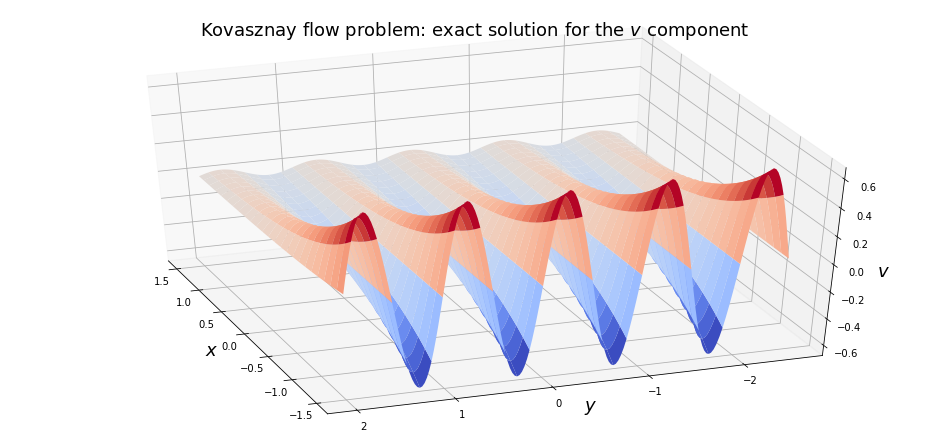

In [2]:
def kovasznay_flow(t, x, y, Re):
    p0 = 1.
    Lambda = Re/2.-sqrt(Re**2/4.+4*pi**2)
    return (1.-exp(Lambda*x)*cos(2.*pi*y),\
            Lambda/(2.*pi)*exp(Lambda*x)*sin(2.*pi*y),\
            p0-1./2*exp(2.*Lambda*x))

h, Re= 2.5e-2, 40.

x, y = meshgrid(arange(-1.5, 1.5, h, dtype=float64),\
                arange(-2.5, 2.0, h, dtype=float64), indexing='ij')
fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, kovasznay_flow(0., x, y, Re)[1],\
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 18})
axes.set_ylabel(r"$y$", {'fontsize': 18})
axes.set_zlabel(r"$v$", {'fontsize': 18})
axes.set_title(r"Kovasznay flow problem: exact solution for the $v$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./kovasznay_flow_exact_v.pdf')
close()

**Taylor decaying**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq1}
\left\lbrace 
\begin{array}{l}
 u = -e^{-2t/\mathrm{Re}} \cos(x) \sin(y) ,\\
 v =  e^{-2t/\mathrm{Re}} \sin(x) \cos(y) ,\\
 p = -e^{-4t/\mathrm{Re}} (\cos(2x) + \cos(2y))/4 ,
\end{array}
\right. 
\end{equation} 
in $[0, 2\pi]\times[0, 2\pi]\times[0, 1]$, where the Reynolds number $\mathrm{Re} = 10^{2}$, 
$\tau=0.05h$.

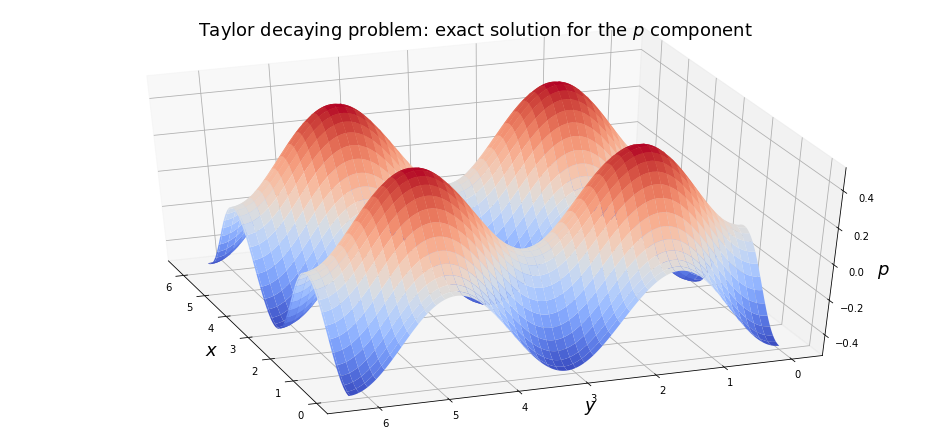

In [3]:
def taylor_decaying(t, x, y, Re):
    return (-exp(-2.*t/Re)*cos(x)*sin(y),
             exp(-2.*t/Re)*sin(x)*cos(y),
            -exp(-4.*t/Re)*(cos(2.*x)+cos(2.*y))/4.)

h, Re = 2.5e-2, 1.e2
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, taylor_decaying(0., x, y, Re)[2], \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 18})
axes.set_ylabel(r"$y$", {'fontsize': 18})
axes.set_zlabel(r"$p$", {'fontsize': 18})
axes.set_title(r"Taylor decaying problem: exact solution for the $p$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()


$$
\begin{align}
 r:\ & \frac{\partial u_r}{\partial t} + u_r \frac{\partial u_r}{\partial r} + \frac{u_\varphi}{r} \frac{\partial u_r}{\partial \varphi} + u_z \frac{\partial u_r}{\partial z} - \frac{u_\varphi^2}{r} = \\
 &\quad = -\frac{\partial p}{\partial r} + \frac{1}{\mathrm{Re}} \left(\frac{1}{r}\frac{\partial}{\partial r}\left(r \frac{\partial u_r}{\partial r}\right) +
 \frac{1}{r^2}\frac{\partial^2 u_r}{\partial \varphi^2} + \frac{\partial^2 u_r}{\partial z^2} - \frac{u_r}{r^2} -
 \frac{2}{r^2}\frac{\partial u_\varphi}{\partial \varphi} \right) + \frac{1}{3\mathrm{Re}} \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial\left(r u_r\right)}{\partial r} + \frac{1}{r}\frac{\partial u_\varphi}{\partial \varphi} + \frac{\partial u_z}{\partial z} \right) \\[8px]
 \varphi:\ & \frac{\partial u_\varphi}{\partial t} + u_r \frac{\partial u_\varphi}{\partial r} +
 \frac{u_\varphi}{r} \frac{\partial u_\varphi}{\partial\varphi} + u_z \frac{\partial u_\varphi}{\partial z} + \frac{u_r u_\varphi}{r} = \\
 &\quad = -\frac{1}{r}\frac{\partial p}{\partial \varphi} +\frac{1}{\mathrm{Re}} \left(\frac{1}{r}\frac{\partial}{\partial r}\left(r \frac{\partial u_{\varphi}}{\partial r}\right) +
 \frac{1}{r^2}\frac{\partial^2 u_{\varphi}}{\partial \varphi^2} + \frac{\partial^2 u_{\varphi}}{\partial z^2} + \frac{2}{r^2}\frac{\partial u_r}{\partial \varphi}-\frac{u_\varphi}{r^2}\right) +
 \frac{1}{3\mathrm{Re}} \frac{1}{r} \frac{\partial}{\partial \varphi} \left( \frac{1}{r}\frac{\partial\left(r u_r\right)}{\partial r} + \frac{1}{r} \frac{\partial u_\varphi}{\partial \varphi} + \frac{\partial u_z}{\partial z} \right) \\[8px]
 z:\ & \frac{\partial u_z}{\partial t} + u_r \frac{\partial u_z}{\partial r} + \frac{u_\varphi}{r} \frac{\partial u_z}{\partial \varphi} +
 u_z \frac{\partial u_z}{\partial z} = \\
 &\quad = -\frac{\partial p}{\partial z} + \frac{1}{\mathrm{Re}}\left(\frac{1}{r}\frac{\partial}{\partial r}\left(r \frac{\partial u_z}{\partial r}\right) +
 \frac{1}{r^2}\frac{\partial^2 u_z}{\partial \varphi^2} + \frac{\partial^2 u_z}{\partial z^2}\right) +
 \frac{1}{3\mathrm{Re}}\frac{\partial}{\partial z} \left( \frac{1}{r}\frac{\partial\left(r u_r\right)}{\partial r} + \frac{1}{r}\frac{\partial u_\varphi}{\partial \varphi} + \frac{\partial u_z}{\partial z} \right).
\end{align}
$$

$$
\frac{1}{r}\frac{\partial}{\partial r}\left(r u_r\right) + \frac{1}{r}\frac{\partial u_\varphi}{\partial \varphi} + \frac{\partial u_z}{\partial z} = 0.
$$

In [4]:
def A_cross1(Nx, Ny):
    Nxy = Nx*Ny
    def jk(j, k):
        return j*Ny+k
    
    row = empty((Nx, Ny, 5), dtype=int)
    for j in range(Nx):
        for k in range(Ny):
            row[j, k] = jk(j, k)

    col = zeros((Nx, Ny, 5), dtype=int)
    for j in range(1, Nx-1):
        for k in range(1, Ny-1):
            col[j, k] =             jk(j-1, k),\
                        jk(j, k-1), jk(j, k), jk(j, k+1),\
                                    jk(j+1, k)
    for j in range(Nx):
        col[j, 0, 0] = jk(j, 0)
        col[j, -1, 0] = jk(j, Ny-1)
    for k in range(1, Ny-1):
        col[0, k, 0]  = jk(0, k)
        col[-1, k, 0] = jk(Nx-1, k)

    data = zeros((Nx, Ny, 5), dtype=float64)
    data[1:-1, 1:-1] =      1.,\
                       1., -4.,  1.,\
                            1.
    data[:, 0, 0] = 1.
    data[:, -1, 0] = 1.
    data[0, 1:-1, 0] = 1.
    data[-1, 1:-1, 0] = 1.

    A = csr_matrix((data.reshape(Nxy*5),\
                    (row.reshape(Nxy*5), col.reshape(Nxy*5))),\
                   shape=(Nxy, Nxy))
    return A

def solve_1(A, f, sol):
    assert sol.shape == f.shape
    b = empty_like(sol)
    b[1:-1,1:-1] = f[1:-1,1:-1]
    b[0,:] = sol[0,:]
    b[-1,:] = sol[-1,:]
    b[:,0] = sol[:,0]
    b[:,-1] = sol[:,-1]

    Nx, Ny = b.shape
    u = spsolve(A, b.reshape(Nx*Ny)).reshape(Nx,Ny)
    return u

In [5]:
def A_cross2(Nx, Ny):
    Nxy = Nx*Ny
    def jk(j, k):
        return j*Ny+k
    
    row = empty((Nx, Ny, 5), dtype=int)
    for j in range(Nx):
        for k in range(Ny):
            row[j, k] = jk(j, k)

    col = zeros((Nx, Ny, 5), dtype=int)
    for j in range(2, Nx-2):
        for k in range(2, Ny-2):
            col[j, k] =             jk(j-2, k),\
                        jk(j, k-2), jk(j, k), jk(j, k+2),\
                                    jk(j+2, k)
    for j in range(Nx):
        col[j, 0, 0] = jk(j, 0)
        col[j, 1, 0] = jk(j, 1)
        col[j, -2, 0] = jk(j, Ny-2)
        col[j, -1, 0] = jk(j, Ny-1)
    for k in range(1, Ny-1):
        col[0, k, 0]  = jk(0, k)
        col[1, k, 0]  = jk(1, k)
        col[-2, k, 0] = jk(Nx-2, k)
        col[-1, k, 0] = jk(Nx-1, k)

    data = zeros((Nx, Ny, 5), dtype=float64)
    data[2:-2, 2:-2] =      1.,\
                       1., -4.,  1.,\
                            1.
    data[:, :2, 0] = 1.
    data[:, -2:, 0] = 1.
    data[:2, 1:-1, 0] = 1.
    data[-2:, 1:-1, 0] = 1.

    A = csr_matrix((data.reshape(Nxy*5),\
                    (row.reshape(Nxy*5), col.reshape(Nxy*5))),\
                   shape=(Nxy, Nxy))
    return A

def solve_2(A, f, sol):
    assert sol.shape == f.shape
    b = empty_like(sol)
    b[2:-2,2:-2] = f[2:-2,2:-2]
    b[:2,:] = sol[:2,:]
    b[-2:,:] = sol[-2:,:]
    b[:,:2] = sol[:,:2]
    b[:,-2:] = sol[:,-2:]

    Nx, Ny = b.shape
    u = spsolve(A, b.reshape(Nx*Ny)).reshape(Nx,Ny)
    return u

In [6]:
def D1x(a):
    return a[2:,1:-1] - a[:-2,1:-1]
def D1y(a):
    return a[1:-1,2:] - a[1:-1,:-2]
def DD1(a):
    return a[2:,1:-1] + a[1:-1,2:] +\
       -4.*a[1:-1,1:-1] +\
           a[:-2,1:-1] +a[1:-1,:-2]
def D1xx(a):
    return a[2:,1:-1] - 2.*a[1:-1,1:-1] + a[:-2,1:-1]
def D1yy(a):
    return a[1:-1,2:] - 2.*a[1:-1,1:-1] + a[1:-1,:-2]

def D2x(a):
    return a[3:-1,2:-2] - a[1:-3,2:-2]
def D2y(a):
    return a[2:-2,3:-1] - a[2:-2,1:-3]
def DD2(a):
    return a[3:-1,2:-2] + a[2:-2,3:-1] +\
       -4.*a[2:-2,2:-2] +\
           a[1:-3,2:-2] +a[2:-2,1:-3]
def D2xx(a):
    return a[3:-1,2:-2] - 2.*a[2:-2,2:-2] + a[1:-3,2:-2]
def D2yy(a):
    return a[2:-2,3:-1] - 2.*a[2:-2,2:-2] + a[2:-2,1:-3]

**FDA1**


Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 415

\begin{equation}
\left\lbrace
\begin{array}{l}
{e_1}_{j,k}^n := \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} = 0, \\[0.2cm]
{e_2}_{j,k}^n := \frac{u_{jk}^{n+1}-u_{jk}^n}{\tau} + \frac{{u_{j+1,k}^n}^2-{u_{j-1,k}^n}^2}{2h}
+ \frac{v_{j,k+1}^n u_{j,k+1}^n-v_{j,k-1}^nu_{j,k-1}^n}{2h} + \frac{p_{j+1,k}^n-p_{j-1,k}^n}{2h} \\[0.2cm]
 \qquad {} - \frac{1}{\mathrm{Re}} \left( \frac{u_{j+1,k}^n-2u_{jk}^n+u_{j-1,k}^n}{h^2} + \frac{u_{j,k+1}^n-2u_{jk}^n+u_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm]
{e_3}_{j,k}^n :=\frac{v_{jk}^{n+1}-v_{jk}^n}{\tau} + \frac{u_{j+1,k}^nv_{j+1,k}^n-u_{j-1,k}^n v_{j-1,k}^n}{2h}
\frac{{v_{j,k+1}^n}^2-{v_{j,k-1}^n}^2}{2h} +  \frac{p_{j,k+1}^n-p_{j,k-1}^n}{2h} \\[0.2cm]
 \qquad  {} - \frac{1}{\mathrm{Re}} \left( \frac{v_{j+1,k}^n-2v_{jk}^n+v_{j-1,k}^n}{h^2} + \frac{v_{j,k+1}^n-2v_{jk}^n+v_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm]
{e_4}_{j,k}^n := \frac{{u_{j+2,k}^n}^2-2{u_{j,k}^n}^2+{u_{j-2,k}^n}^2}{4h^2} +
\frac{{v_{j,k+2}^n}^2-2{v_{j,k}^n}^2+{v_{j,k-2}^n}^2}{4h^2} \\[0.2cm]
\qquad {} + 2\frac{u_{j+1,k+1}^n v_{j+1,k+1}^n- u_{j+1,k-1}^n v_{j+1,k-1}^n-u_{j-1,k+1}^n v_{j-1,k+1}^n+
u_{j-1,k-1}^n v_{j-1,k-1}^n}{4h^2}\\[0.2cm]
 \qquad {} + \frac{p_{j+2,k}^n-2p_{jk}^n+p_{j-2,k}^n}{4h^2}  + \frac{p_{j,k+2}^n-2p_{jk}^n+p_{j,k-2}^n}{4h^2} 
\\[0.2cm] 
\qquad {} + \frac{2}{\mathrm{Re}}\frac{-u_{j+2,k}^n + 4u_{j+1,k}^n -4u_{j-1,k}^n + u_{j-2,k}^n
- u_{j+1,k+1}^n - u_{j+1,k-1}^n + u_{j-1,k+1}^n + u_{j-1,k-1}^n}{4h^3}
\\[0.2cm] 
\qquad {} + \frac{2}{\mathrm{Re}}\frac{-v_{j,k+2}^n + 4v_{j,k+1}^n - 4v_{j,k-1}^n + v_{j,k-1}^n
- v_{j+1,k+1}^n - v_{j-1,k+1}^n + v_{j+1,k-1}^n + v_{j-1,k-1}^n}{4h^3}
= 0\,.
\end{array}
\right.
\end{equation}

In [7]:
def FDA1(sol, exact, tau, h, Re):
    u, v, p = sol
    u1, v1, p1 = copy(exact)

    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/h*((\
        u[2:,1:-1]**2-u[:-2,1:-1]**2+\
        v[1:-1,2:]*u[1:-1,2:]-v[1:-1,:-2]*u[1:-1,:-2]+\
        p[2:,1:-1]-p[:-2,1:-1])/2.-(\
        u[2:,1:-1]+u[:-2,1:-1]+u[1:-1,2:]+u[1:-1,:-2]-4.*u[1:-1,1:-1])/(h*Re))

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/h*((\
        u[2:,1:-1]*v[2:,1:-1]-u[:-2,1:-1]*v[:-2,1:-1]+\
        v[1:-1,2:]**2-v[1:-1,:-2]**2+\
        p[1:-1,2:]-p[1:-1,:-2])/2.-(\
        v[2:,1:-1]+v[:-2,1:-1]+v[1:-1,2:]+v[1:-1,:-2]-4.*v[1:-1,1:-1])/(h*Re))

    p1[2:-2,2:-2] = -(\
        u1[4:,2:-2]**2-2.*u1[2:-2,2:-2]**2+u1[:-4,2:-2]**2+\
        2.*(u1[3:-1,3:-1]*v1[3:-1,3:-1]-u1[3:-1,1:-3]*v1[3:-1,1:-3]-\
            u1[1:-3,3:-1]*v1[1:-3,3:-1]+u1[1:-3,1:-3]*v1[1:-3,1:-3])+
        v1[2:-2,4:]**2-2.*v1[2:-2,2:-2]**2+v1[2:-2,:-4]**2+\
        2./(h*Re)*(-u1[4:,2:-2]+4.*u1[3:-1,2:-2]-4.*u1[1:-3,2:-2]+u1[:-4,2:-2]-\
                u1[3:-1,3:-1]-u1[3:-1,1:-3]+u1[1:-3,3:-1]+u1[1:-3,1:-3])+
        2./(h*Re)*(-v1[2:-2,4:]+4.*v1[2:-2,3:-1]-4.*v1[2:-2,1:-3]+v1[2:-2,:-4]-\
                v1[3:-1,3:-1]-v1[1:-3,3:-1]+v1[3:-1,1:-3]+v1[1:-3,1:-3]))
    return u1, v1, p1

**FDA2**

Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 417

\begin{equation}
\left\lbrace
\begin{array}{l}
{e_1}_{j,k}^n := \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} = 0, \\[0.2cm]
{e_2}_{j,k}^n := \frac{u_{jk}^{n+1}-u_{jk}^n}{\tau} + u_{j,k}^n\frac{{u_{j+1,k}^n}-{u_{j-1,k}^n}}{2h}
+ v_{j,k}^n\frac{u_{j,k+1}^n-u_{j,k-1}^n}{2h} + \frac{p_{j+1,k}^n-p_{j-1,k}^n}{2h} \\[0.2cm]
 \qquad {} - \frac{1}{\mathrm{Re}} \left( \frac{u_{j+1,k}^n-2u_{jk}^n+u_{j-1,k}^n}{h^2} + \frac{u_{j,k+1}^n-2u_{jk}^n+u_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm] %\label{clas_2}
{e_3}_{j,k}^n :=\frac{v_{jk}^{n+1}-v_{jk}^n}{\tau} + u_{j,k}^n\frac{v_{j+1,k}^n-
v_{j-1,k}^n}{2h}
+v_{j,k}^n\frac{{v_{j,k+1}^n}-{v_{j,k-1}^n}}{2h} +  \frac{p_{j,k+1}^n-p_{j,k-1}^n}{2h} \\[0.2cm]
 \qquad  {} - \frac{1}{\mathrm{Re}} \left( \frac{v_{j+1,k}^n-2v_{jk}^n+v_{j-1,k}^n}{h^2} + \frac{v_{j,k+1}^n-2v_{jk}^n+v_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm]
{e_4}_{j,k}^n := \left(\frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h}\right)^2 
+ 2\frac{v_{j+1,k}^n-v_{j-1,k}^n}{2h} \frac{u_{j,k+1}^n-u_{j,k-1}^n}{2h}
+  \left(\frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h}\right)^2 \\[0.2cm]
 \qquad {} + \frac{p_{j+1,k}^n-2p_{jk}^n+p_{j-1,k}^n}{h^2}  + \frac{p_{j,k+1}^n-2p_{jk}^n+p_{j,k-1}^n}{h^2} =
 0\,.
\end{array}
\right.
\end{equation}

In [8]:
def FDA2(sol, exact, tau, h, Re):
    u, v, p = sol
    u1, v1, p1 = copy(exact)

    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/h*((\
        u[1:-1,1:-1]*(u[2:,1:-1]-u[:-2,1:-1])+\
        v[1:-1,1:-1]*(u[1:-1,2:]-u[1:-1,:-2])+\
        p[2:,1:-1]-p[:-2,1:-1])/2.-(\
        u[2:,1:-1]+u[:-2,1:-1]+u[1:-1,2:]+u[1:-1,:-2]-4.*u[1:-1,1:-1])/(h*Re))

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/h*((\
        u[1:-1,1:-1]*(v[2:,1:-1]-v[:-2,1:-1])+\
        v[1:-1,1:-1]*(v[1:-1,2:]-v[1:-1,:-2])+\
        p[1:-1,2:]-p[1:-1,:-2])/2.-(\
        v[2:,1:-1]+v[:-2,1:-1]+v[1:-1,2:]+v[1:-1,:-2]-4.*v[1:-1,1:-1])/(h*Re))

    p1[1:-1,1:-1] = -(\
        (u1[2:,1:-1]-u1[:-2,1:-1])**2+\
        2.*(v1[2:,1:-1]-v1[:-2,1:-1])*(u1[1:-1,2:]-u1[1:-1,:-2])+\
        (v1[1:-1,2:]-v1[1:-1,:-2])**2)/4.

    return u1, v1, p1

**FDA3**


Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 417

\begin{equation}
\left\lbrace
\begin{array}{l}
{e_1}_{j,k}^n := \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} = 0, \\[0.2cm]
{e_2}_{j,k}^n := \frac{u_{jk}^{n+1}-u_{jk}^n}{\tau} + \frac{{u_{j+1,k}^n}^2-{u_{j-1,k}^n}^2}{2h}
+ \frac{v_{j,k+1}^n u_{j,k+1}^n-v_{j,k-1}^nu_{j,k-1}^n}{2h} + \frac{p_{j+1,k}^n-p_{j-1,k}^n}{2h} \\[0.2cm]
 \qquad {} - \frac{1}{\mathrm{Re}} \left( \frac{u_{j+1,k}^n-2u_{jk}^n+u_{j-1,k}^n}{h^2} + \frac{u_{j,k+1}^n-2u_{jk}^n+u_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm]
{e_3}_{j,k}^n :=\frac{v_{jk}^{n+1}-v_{jk}^n}{\tau} + \frac{u_{j+1,k}^nv_{j+1,k}^n-u_{j-1,k}^n v_{j-1,k}^n}{2h}
\frac{{v_{j,k+1}^n}^2-{v_{j,k-1}^n}^2}{2h} +  \frac{p_{j,k+1}^n-p_{j,k-1}^n}{2h} \\[0.2cm]
 \qquad  {} - \frac{1}{\mathrm{Re}} \left( \frac{v_{j+1,k}^n-2v_{jk}^n+v_{j-1,k}^n}{h^2} + \frac{v_{j,k+1}^n-2v_{jk}^n+v_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm]
{e_4}_{j,k}^n := \frac{{u_{j+2,k}^n}^2-2{u_{j,k}^n}^2+{u_{j-2,k}^n}^2}{4h^2} +
\frac{{v_{j,k+2}^n}^2-2{v_{j,k}^n}^2+{v_{j,k-2}^n}^2}{4h^2} \\[0.2cm]
\qquad {} + 2\frac{u_{j+1,k+1}^n v_{j+1,k+1}^n- u_{j+1,k-1}^n v_{j+1,k-1}^n-u_{j-1,k+1}^n v_{j-1,k+1}^n+
u_{j-1,k-1}^n v_{j-1,k-1}^n}{4h^2}\\[0.2cm]
 \qquad {} + \frac{p_{j+2,k}^n-2p_{jk}^n+p_{j-2,k}^n}{4h^2}  + \frac{p_{j,k+2}^n-2p_{jk}^n+p_{j,k-2}^n}{4h^2}
= 0\,.
\end{array}
\right.
\end{equation}

In [9]:
def FDA3(sol, exact, tau, h, Re):
    u, v, p = sol
    u1, v1, p1 = copy(exact)

    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/h*((\
        u[2:,1:-1]**2-u[:-2,1:-1]**2+\
        v[1:-1,2:]*u[1:-1,2:]-v[1:-1,:-2]*u[1:-1,:-2]+\
        p[2:,1:-1]-p[:-2,1:-1])/2.-(\
        u[2:,1:-1]+u[:-2,1:-1]+u[1:-1,2:]+u[1:-1,:-2]-4.*u[1:-1,1:-1])/(h*Re))

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/h*((\
        u[2:,1:-1]*v[2:,1:-1]-u[:-2,1:-1]*v[:-2,1:-1]+\
        v[1:-1,2:]**2-v[1:-1,:-2]**2+\
        p[1:-1,2:]-p[1:-1,:-2])/2.-(\
        v[2:,1:-1]+v[:-2,1:-1]+v[1:-1,2:]+v[1:-1,:-2]-4.*v[1:-1,1:-1])/(h*Re))

    p1[2:-2,2:-2] = -(\
        u1[4:,2:-2]**2-2.*u1[2:-2,2:-2]**2+u1[:-4,2:-2]**2+\
        2.*(u1[3:-1,3:-1]*v1[3:-1,3:-1]-u1[3:-1,1:-3]*v1[3:-1,1:-3]-\
            u1[1:-3,3:-1]*v1[1:-3,3:-1]+u1[1:-3,1:-3]*v1[1:-3,1:-3])+
        v1[2:-2,4:]**2-2.*v1[2:-2,2:-2]**2+v1[2:-2,:-4]**2)
    return u1, v1, p1

**FDA4**

\begin{equation}
\left\lbrace
\begin{array}{l}
{e_1}_{j,k}^n := \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} = 0, \\[0.2cm]
{e_2}_{j,k}^n := \frac{u_{jk}^{n+1}-u_{jk}^n}{\tau} + u_{j,k}^n\frac{{u_{j+1,k}^n}-{u_{j-1,k}^n}}{2h}
+ v_{j,k}^n\frac{u_{j,k+1}^n-u_{j,k-1}^n}{2h} + \frac{p_{j+1,k}^n-p_{j-1,k}^n}{2h} \\[0.2cm]
 \qquad {} - \frac{1}{\mathrm{Re}} \left( \frac{u_{j+1,k}^n-2u_{jk}^n+u_{j-1,k}^n}{h^2} + \frac{u_{j,k+1}^n-2u_{jk}^n+u_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm] %\label{clas_2}
{e_3}_{j,k}^n :=\frac{v_{jk}^{n+1}-v_{jk}^n}{\tau} + u_{j,k}^n\frac{v_{j+1,k}^n-
v_{j-1,k}^n}{2h}
+v_{j,k}^n\frac{{v_{j,k+1}^n}-{v_{j,k-1}^n}}{2h} +  \frac{p_{j,k+1}^n-p_{j,k-1}^n}{2h} \\[0.2cm]
 \qquad  {} - \frac{1}{\mathrm{Re}} \left( \frac{v_{j+1,k}^n-2v_{jk}^n+v_{j-1,k}^n}{h^2} + \frac{v_{j,k+1}^n-2v_{jk}^n+v_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm]
{e_4}_{j,k}^n := \frac{u_{j+1,k}^n({u_{j+2,k}^n}-{u_{j,k}^n}) -
u_{j-1,k}^n({u_{j,k}^n}-{u_{j-2,k}^n})}{4h^2} \\[0.2cm]
\qquad {} +
\frac{v_{j+1,k}^n(u_{j+1,k+1}^n-u_{j+1,k-1}^n) - v_{j-1,k}^n(u_{j-1,k+1}^n-u_{j-1,k-1}^n)
+ u_{j,k+1}^n(v_{j+1,k+1}^n-v_{j-1,k+1}^n) - u_{j,k-1}^n(v_{j+1,k-1}^n-v_{j-1,k-1}^n)}{4h^2}\\[0.2cm]
\qquad {}+ \frac{v_{j,k+1}^n({v_{j,k+2}^n}-{v_{j,k}^n})
- v_{j,k-1}^n({v_{j,k}^n}-{v_{j,k-2}^n})}{4h^2}  \\[0.2cm]
 \qquad {} + \frac{p_{j+2,k}^n-2p_{jk}^n+p_{j-2,k}^n}{4h^2}  + \frac{p_{j,k+2}^n-2p_{jk}^n+p_{j,k-2}^n}{4h^2}\\[0.2cm]
\qquad {} + \frac{2}{\mathrm{Re}}\frac{-u_{j+2,k}^n + 4u_{j+1,k}^n -4u_{j-1,k}^n + u_{j-2,k}^n
- u_{j+1,k+1}^n - u_{j+1,k-1}^n + u_{j-1,k+1}^n + u_{j-1,k-1}^n}{4h^3}
\\[0.2cm] 
\qquad {} + \frac{2}{\mathrm{Re}}\frac{-v_{j,k+2}^n + 4v_{j,k+1}^n - 4v_{j,k-1}^n + v_{j,k-1}^n
- v_{j+1,k+1}^n - v_{j-1,k+1}^n + v_{j+1,k-1}^n + v_{j-1,k-1}^n}{4h^3}
= 0\,.
\end{array}
\right.
\end{equation}

In [10]:
def FDA4(sol, exact, tau, h, Re):
    u, v, p = sol
    u1, v1, p1 = copy(exact)

    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/h*((\
        u[1:-1,1:-1]*(u[2:,1:-1]-u[:-2,1:-1])+\
        v[1:-1,1:-1]*(u[1:-1,2:]-u[1:-1,:-2])+\
        p[2:,1:-1]-p[:-2,1:-1])/2.-(\
        u[2:,1:-1]+u[:-2,1:-1]+u[1:-1,2:]+u[1:-1,:-2]-4.*u[1:-1,1:-1])/(h*Re))

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/h*((\
        u[1:-1,1:-1]*(v[2:,1:-1]-v[:-2,1:-1])+\
        v[1:-1,1:-1]*(v[1:-1,2:]-v[1:-1,:-2])+\
        p[1:-1,2:]-p[1:-1,:-2])/2.-(\
        v[2:,1:-1]+v[:-2,1:-1]+v[1:-1,2:]+v[1:-1,:-2]-4.*v[1:-1,1:-1])/(h*Re))

    p1[2:-2,2:-2] = -(\
        u1[3:-1,2:-2]*(u1[4:,2:-2] - u1[2:-2,2:-2]) - u1[1:-3,2:-2]*(u1[2:-2,2:-2] - u1[:-4,2:-2])+\
        v1[3:-1,2:-2]*(u1[3:-1,3:-1] - u1[3:-1,1:-3]) - v1[1:-3,2:-2]*(u1[1:-3,3:-1] - u1[1:-3,1:-3])+\
        u1[2:-2,3:-1]*(v1[3:-1,3:-1] - v1[1:-3,3:-1]) - u1[2:-2,1:-3]*(v1[3:-1,1:-3] - v1[1:-3,1:-3])+\
        v1[2:-2,3:-1]*(v1[2:-2,4:] - v1[2:-2,2:-2]) - v1[2:-2,1:-3]*(v1[2:-2,2:-2] - v1[2:-2,:-4])+\
        2./(h*Re)*(-u1[4:,2:-2]+4.*u1[3:-1,2:-2]-4.*u1[1:-3,2:-2]+u1[:-4,2:-2]-\
                u1[3:-1,3:-1]-u1[3:-1,1:-3]+u1[1:-3,3:-1]+u1[1:-3,1:-3])+
        2./(h*Re)*(-v1[2:-2,4:]+4.*v1[2:-2,3:-1]-4.*v1[2:-2,1:-3]+v1[2:-2,:-4]-\
                v1[3:-1,3:-1]-v1[1:-3,3:-1]+v1[3:-1,1:-3]+v1[1:-3,1:-3]))

    return u1, v1, p1

In [11]:
fda = (\
(FDA1, A_cross2, solve_2),\
(FDA2, A_cross1, solve_1),\
(FDA3, A_cross2, solve_2),\
(FDA4, A_cross2, solve_2),\
)

In [12]:
def error(f, g):
    return max((abs(f-g)/(1.+abs(g))).flat)

def div(u, v, h):
    return norm((u[3:-1,2:-2]-u[1:-3,2:-2])/(2*h)+\
                (v[2:-2,3:-1]-v[2:-2,1:-3])/(2*h))

def sol(args):
    exact, x, y, t1, fda, h, tau, a, s, Re = args
    print(str(fda).split(' ')[1], "h =", h, "begin")
    err = zeros((5, (int(ceil(t1/tau)))), dtype=float64)
    A = a(x.shape[0], x.shape[1])
    t = 0.
    u, v, p = exact(t, x, y, Re)
    for n in range(err.shape[1]):
        t += tau
        sol = exact(t, x, y, Re)
        u1, v1, p1 = fda((u, v, p), sol, tau, h, Re)
        p1 = s(A, p1, sol[2])
        u, v, p = u1, v1, p1

        err[:, n] = t, error(u, sol[0]), error(v, sol[1]), error(p, sol[2]),  div(u, v, h)

        if max(err[1:, n]) > 1.e1:
            break
    print(str(fda).split(' ')[1], "h =", h, " end")
    return (args, n, err)

# Taylor decaying

In [13]:
tasks = []
for m in range(-1, 3):
    h = 0.1/2**m
    tau = 0.05*h
    print("h =", h, "  steps =", int(ceil(1.0/tau)))
    x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                    arange(0., 2.*pi, h, dtype=float64), indexing='ij')

    for f, a, s in fda:
        args = taylor_decaying, x, y, 6.0, f, h, tau, a, s, 100.
        tasks.append(args)
len(tasks)

h = 0.2   steps = 100
h = 0.1   steps = 200
h = 0.05   steps = 400
h = 0.025   steps = 800


16

In [14]:
proc = 6
clock = time.perf_counter()
pool = Pool(processes=proc)
res = pool.map_async(sol, tasks)
pool.close()
pool.join()
res_taylor_decaying = res.get()
print("Time: %.3f * %d" % (time.perf_counter() - clock, proc))

FDA1 h = 0.2 begin
FDA2 h = 0.2 begin
FDA3 h = 0.2 begin
FDA4 h = 0.2 begin
FDA2 h = 0.1 begin
FDA1 h = 0.1 begin
FDA1 h = 0.2  end
FDA3 h = 0.1 begin
FDA4 h = 0.2  end
FDA4 h = 0.1 begin
FDA3 h = 0.2  end
FDA1 h = 0.05 begin
FDA2 h = 0.2  end
FDA2 h = 0.05 begin
FDA4 h = 0.1  end
FDA3 h = 0.05 begin
FDA1 h = 0.1  end
FDA4 h = 0.05 begin
FDA3 h = 0.1  end
FDA1 h = 0.025 begin
FDA2 h = 0.1  end
FDA2 h = 0.025 begin
FDA4 h = 0.05  end
FDA3 h = 0.025 begin
FDA1 h = 0.05  end
FDA4 h = 0.025 begin
FDA3 h = 0.05  end
FDA2 h = 0.05  end
FDA3 h = 0.025  end
FDA1 h = 0.025  end
FDA4 h = 0.025  end
FDA2 h = 0.025  end
Time: 4908.532 * 6


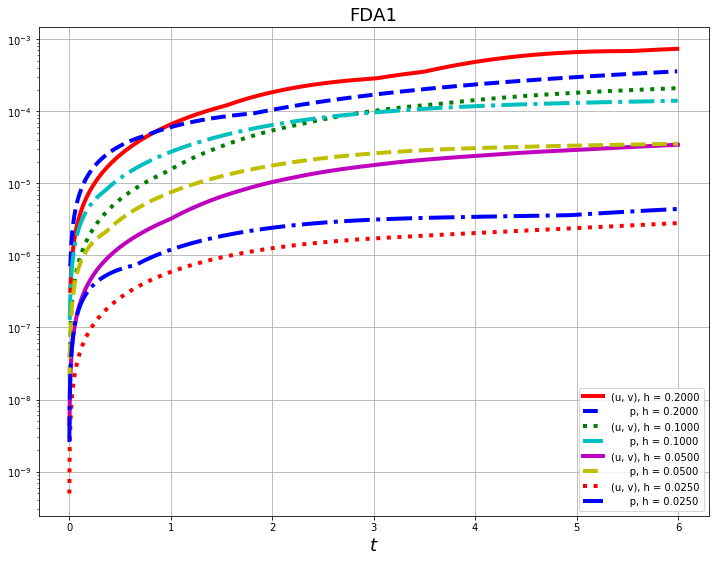

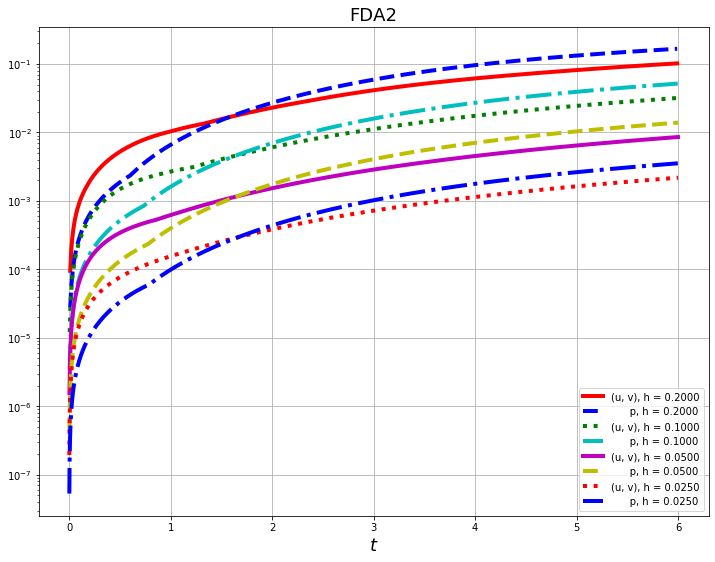

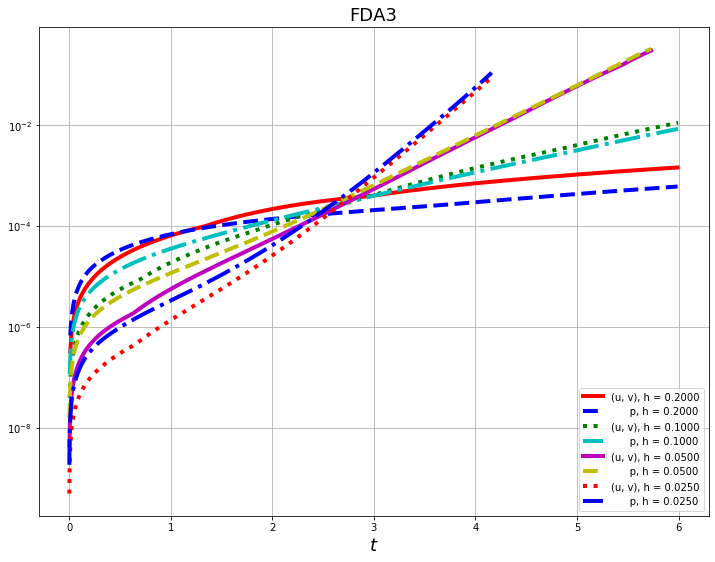

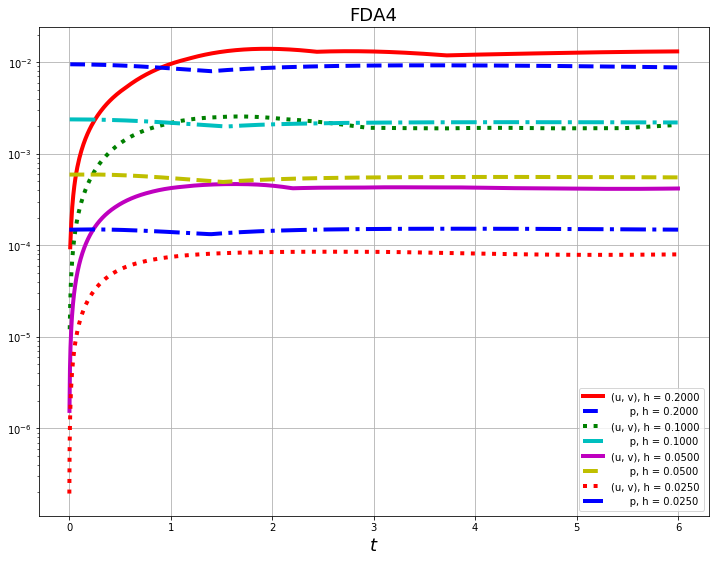

In [15]:
l = ['(u, v)', 'v', '      p', 'div']
for f, a, s in fda:
    lstyle = cycle(('-', '--', ':', '-.'))
    color = cycle('rbgcmy')
    res = sorted((r for r in res_taylor_decaying if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    figure(figsize=(12, 9))
    title(str(f).split(' ')[1], {'fontsize': 18})
    for r in res:
        for k in [0, 2]:
            semilogy(r[2][0][:r[1]],\
                     r[2][k+1][:r[1]],\
                     label="%s, h = %.4f" % (l[k], r[0][5]),
                     linestyle=next(lstyle),
                     color=next(color),
                     linewidth=4)
    xlabel(r'$t$', {'fontsize': 18})
#     ylim((10**-15, 10**1))
    grid()
    legend(loc='lower right', fancybox=True)
#     savefig("taylor_decaying_%s.pdf" % str(f).split(' ')[1])
    show()
    close()

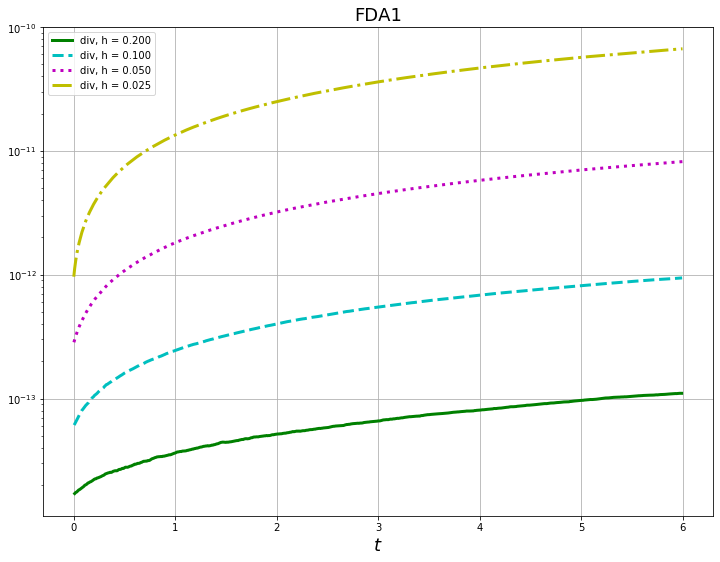

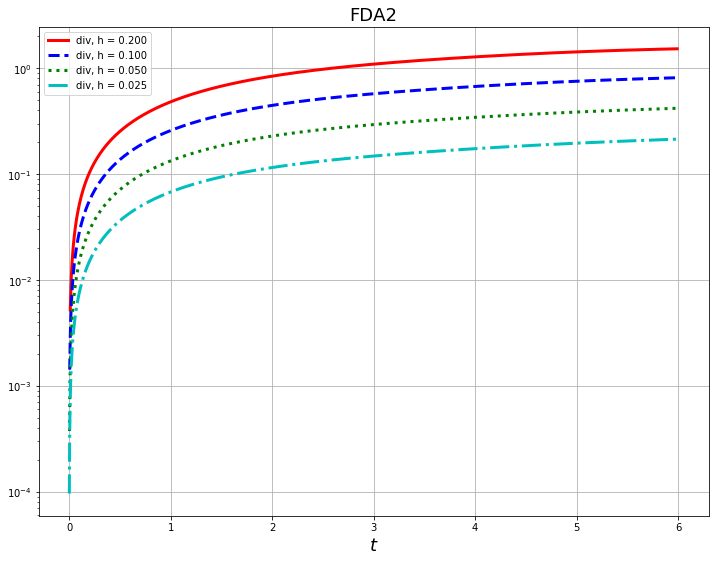

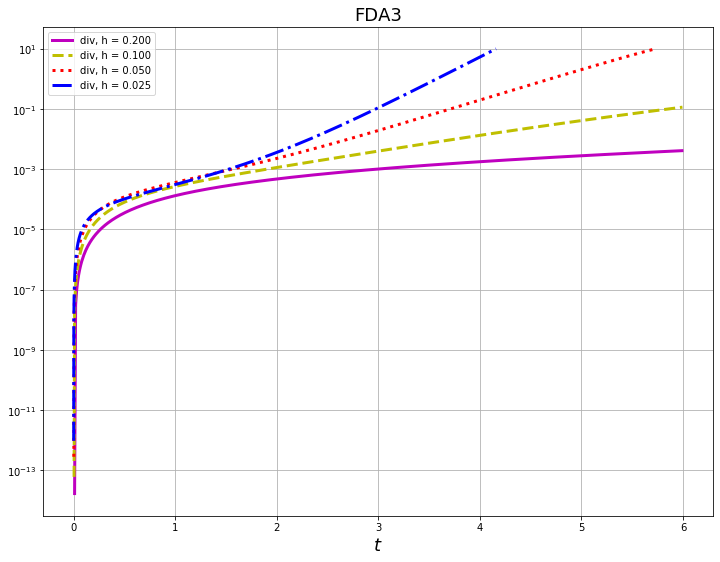

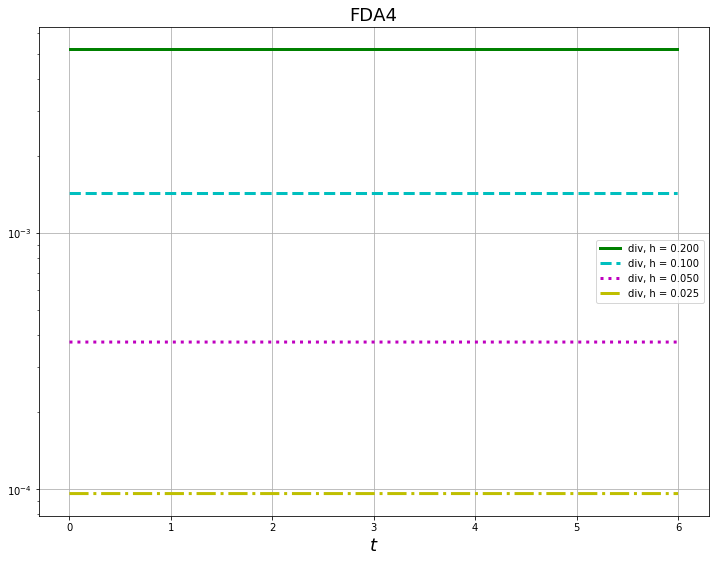

In [16]:
l = ['u', 'v', 'p', 'div']
for f, a, s in fda:
    res = sorted((r for r in res_taylor_decaying if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    figure(figsize=(12, 9))
    title(str(f).split(' ')[1], {'fontsize': 18})
    for r in res:
        for k in [3]:
            semilogy(r[2][0][:r[1]],\
                     r[2][k+1][:r[1]],\
                     label="%s, h = %.3f" % (l[k], r[0][5]),
                     linestyle=next(lstyle),
                     color=next(color),
                     linewidth=3)
    xlabel(r'$t$', {'fontsize': 18})
#     ylim((10**-15, 10**1))
    grid()
    legend(loc='best', fancybox=True)
    show()
    close()

No handles with labels found to put in legend.


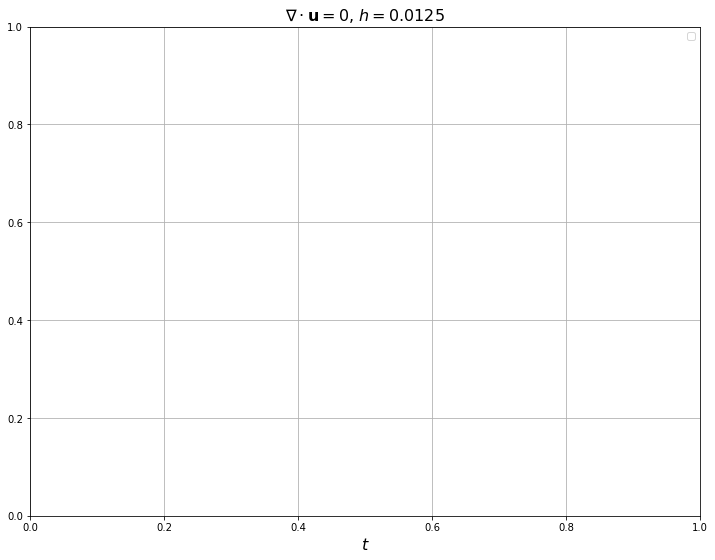

In [17]:
lstyle = cycle(('-', '--', ':', '-.'))
color = cycle('rbgcmy')
l = ['u', 'v', 'p', 'div']
figure(figsize=(12, 9))
title(r"$\nabla \cdot \mathbf{u} = 0$, $h=0.0125$", {'fontsize': 16})
for f, a, s in fda:
    res = (r for r in res_taylor_decaying if r[0][4] == f and r[0][5] == 0.0125)
    for r in res:
        for k in [3]:
            semilogy(r[2][0][100:r[1]],\
                     r[2][k+1][100:r[1]],\
                     label=str(f).split(' ')[1],
                     linestyle=next(lstyle),
                     color=next(color),
                     linewidth=3)
xlabel(r'$t$', {'fontsize': 16})
# ylim((10**-15, 10**1))
grid()
legend(loc='best', fancybox=True)
# savefig("div_0.025_taylor_decaying.pdf")
show()
close()

In [18]:
def tbl(res):
    print(r"""\begin{center}
%s

\begin{tabular}{rrrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{Error in u} &
\multicolumn{1}{c}{Error in v} &
\multicolumn{1}{c}{Error in p} &
\multicolumn{1}{c}{Error in div} \\ \hline""" % res[0])
    for l in res[1:]:
#         print(l)
        print(r' {:.2e} & {:.2f} & {:.2e} & {:.2e} & {:.2e} & {:.2e} \\'.format(*l))
    print(r"""\hline
\end{tabular}
\end{center}
""")

In [19]:
t = []
for f, a, s in fda:
    t.append([str(f).split(' ')[1]])
    res = sorted((r for r in res_taylor_decaying if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    for r in res:
        t[-1].append([r[0][5], r[2][0][r[1]-1]])
        for k in range(4):
            t[-1][-1].append(r[2][k+1][r[1]-1])
    print(t[-1])

['FDA1', [0.2, 5.989999999999917, 0.0007388634631695202, 0.0007277234677208225, 0.0003592281519681808, 1.101468894010659e-13], [0.1, 5.994999999999894, 0.0002101850103295986, 0.00021689485879207942, 0.00014055987622946543, 9.41378148508697e-13], [0.05, 5.997500000000238, 3.4404682819223646e-05, 3.4719787836513886e-05, 3.552758015563079e-05, 8.185555525816723e-12], [0.025, 5.998749999999878, 2.8121226074272037e-06, 2.8231553112650007e-06, 4.419474486238642e-06, 6.670802050431522e-11]]
['FDA2', [0.2, 5.989999999999917, 0.10181513228291204, 0.10203214353166805, 0.16634393202113784, 1.5236397195058242], [0.1, 5.994999999999894, 0.03183353456492993, 0.03184829786892767, 0.05159734317904614, 0.8126065081496643], [0.05, 5.997500000000238, 0.008552315644054481, 0.00855247082819514, 0.013882132707634118, 0.418243430916416], [0.025, 5.998749999999878, 0.002179591159259384, 0.0021798009169928926, 0.0035384535298284515, 0.21372383098230513]]
['FDA3', [0.2, 5.989999999999917, 0.001436130381204552, 

In [20]:
for l in t:
    tbl(l)

\begin{center}
FDA1

\begin{tabular}{rrrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{Error in u} &
\multicolumn{1}{c}{Error in v} &
\multicolumn{1}{c}{Error in p} &
\multicolumn{1}{c}{Error in div} \\ \hline
 2.00e-01 & 5.99 & 7.39e-04 & 7.28e-04 & 3.59e-04 & 1.10e-13 \\
 1.00e-01 & 5.99 & 2.10e-04 & 2.17e-04 & 1.41e-04 & 9.41e-13 \\
 5.00e-02 & 6.00 & 3.44e-05 & 3.47e-05 & 3.55e-05 & 8.19e-12 \\
 2.50e-02 & 6.00 & 2.81e-06 & 2.82e-06 & 4.42e-06 & 6.67e-11 \\
\hline
\end{tabular}
\end{center}

\begin{center}
FDA2

\begin{tabular}{rrrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{Error in u} &
\multicolumn{1}{c}{Error in v} &
\multicolumn{1}{c}{Error in p} &
\multicolumn{1}{c}{Error in div} \\ \hline
 2.00e-01 & 5.99 & 1.02e-01 & 1.02e-01 & 1.66e-01 & 1.52e+00 \\
 1.00e-01 & 5.99 & 3.18e-02 & 3.18e-02 & 5.16e-02 & 8.13e-01 \\
 5.00e-02 & 6.00 & 8.55e-03 & 8.55e-03 & 1.39e-02 & 4.18e-01 \\
 2.50e-02 & 6.00 & 2.18e-03 & 2.18e

In [21]:
assert False

AssertionError: 

# Kovasznay flow

In [ ]:
tasks, n = [], 5
for m in range(n):
    h = 0.1/2**m
    tau = 0.05*h
    print("h =", h, "  steps =", int(ceil(1.0/tau)))
    x, y = meshgrid(arange(-1.5, 1.5, h, dtype=float64),\
                    arange(-2.5, 2.0, h, dtype=float64), indexing='ij')    

    for f, a, s in fda:
        args = kovasznay_flow, x, y, 1.0, f, h, tau, a, s, 40.
        tasks.append(args)
len(tasks)

In [ ]:
proc = 6
clock = time.perf_counter()
pool = Pool(processes=proc)
res = pool.map_async(sol, tasks)
pool.close()
pool.join()
res_kovasznay_flow = res.get()
print("Time: %.3f * %d" % (time.perf_counter() - clock, proc))

In [ ]:
l = ['u', 'v', 'p', 'div']
for f, a, s in fda:
    res = sorted((r for r in res_kovasznay_flow if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    figure(figsize=(12, 9))
    title(str(f).split(' ')[1], {'fontsize': 18})
    for r in res:
        for k in range(2):
            semilogy(r[2][0][:r[1]],\
                     r[2][k+1][:r[1]],\
                     label="%s, h = %.3f" % (l[k], r[0][5]),
                     linestyle=next(lstyle),
                     color=next(color),
                     linewidth=3)
    xlabel(r'$t$', {'fontsize': 18})
#     ylim((10**-15, 10**1))
    grid()
    legend(loc='best', fancybox=True)
    show()
    close()

In [ ]:
l = ['u', 'v', 'p', 'div']
for f, a, s in fda:
    res = sorted((r for r in res_kovasznay_flow if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    figure(figsize=(12, 9))
    title(str(f).split(' ')[1], {'fontsize': 18})
    for r in res:
        for k in [3]:
            semilogy(r[2][0][:r[1]],\
                     r[2][k+1][:r[1]],\
                     label="%s, h = %.3f" % (l[k], r[0][5]),
                     linestyle=next(lstyle),
                     color=next(color),
                     linewidth=3)
    xlabel(r'$t$', {'fontsize': 18})
#     ylim((10**-15, 10**1))
    grid()
    legend(loc='best', fancybox=True)
    show()
    close()

In [ ]:
def tbl(exact, res):
    print(r"""\begin{center}
%s\\
\begin{tabular}{rrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{$\left\|u-u_{ext}\right\|$} &
\multicolumn{1}{c}{$\left\|v-v_{ext}\right\|$} &
\multicolumn{1}{c}{$\left\|p-p_{ext}\right\|$} \\""" % exact)
    for l in res:
        fda, r = l
        print(r"  \hline \multicolumn{5}{c}{%s} \\" % fda)
        for h, n, err in r:
            print(r'  {:.1e} & {:.2f} & {:.2e} & {:.2e} & {:.2e} \\'.format(h, *err[n-1,:]))
    print(r"""\hline
\end{tabular}
\end{center}
""")

tbl("Taylor decaying problem", res1)

tbl(" Kovasznay flow problem", res1)

In [ ]:
result[0]

In [ ]:
i = cycle(('-', '--', ':', '-.'))

In [ ]:
for a in range(5): print(i)

In [ ]:
next(i)